# Fitting

## Objectives

* Learn how to interpolate using several methods
* Learn how to perform a simple fit on data
* Learn about various tools for data fitting

Section 7.5 and on

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's prepare a set of "semi-continuous" values to interpolate on.

In [2]:
x = np.linspace(0, 200, 100)

And, here's the data for a cross-section of resonant scattering of a neutron from a nucleus.

In [3]:
x_data = np.linspace(0, 200, 9)
y_data = np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])
# e_data = np.array([9.34, 17.9, 41.5, 85.5, 51.5,
#                    21.5, 10.8, 6.29, 4.14])
e_data = np.array([5, 7, 10, 12, 10, 7, 5, 4, 4])

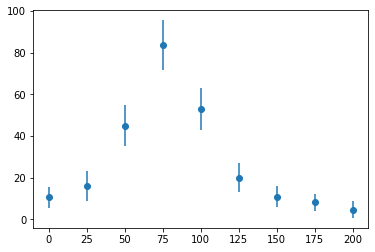

In [4]:
fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, e_data, fmt="o")
plt.show()

## Linear interpolation

In many cases, a function f(x) is only known at a set of points ${x_1, x_2, ..., x_N}$, and we are interested estimating its value at an arbitrary point.

Estimating f(x) with $x \in [x_1,x_N]$ is called interpolation. 

Estimating f(x) with $x \notin [x_1,x_N]$ is called extrapolation.

We could numerically interpolate between values. The numpy function `interp` does this for us:

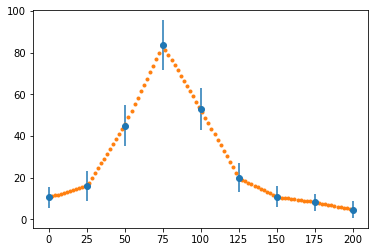

In [5]:
y = np.interp(x, x_data, y_data)
fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, e_data, fmt="o")
ax.plot(x, y, ".")
plt.show()

## Lagrange interpolation

As you can see, Linear interpolation does not capture the actual behavior of the data. A very useful method is the so called Lagrange interpolation, which defines a polynomial of degree $n-1$ that passes over the existing $n$ points. The form of the polynomial was first published by Waring (1779), rediscovered by Euler in 1783, and published by Lagrange in 1795 (Jeffreys and Jeffreys 1988, Book: methods of mathematical physics, ISBN-10: 0521664020). 

The idea is simple, suppose you have $(x_1,y_1),(x_2,y_2),\cdots,(x_n,y_n)$, then, we want
$$
P(x) = \lambda_1(x) y_1 + \lambda_2(x) y_2 + \lambda_3(x) y_3 + ... + \lambda_N(x) y_N
$$

We can build our own Lagrange interpolation function:

$$
g(x)
=
\sum_{i=1}^{n}
g_i \lambda_i(x)
$$

$$
\lambda_i(x)
=
\prod_{j(\ne i)=1}^{n}
\frac{x - x_j}
     {x_i - x_j}
$$
where $x_i$ are the existing points, $y_i$ is the function value on those points and $g_i$ are the corresponding $g(x_i)$, which are also known. 

In [6]:
nx, ny = (4, 3)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
print(x)
print(y)
xv, yv = np.meshgrid(x, y)
print(xv)
print(yv)

[0.         0.33333333 0.66666667 1.        ]
[0.  0.5 1. ]
[[0.         0.33333333 0.66666667 1.        ]
 [0.         0.33333333 0.66666667 1.        ]
 [0.         0.33333333 0.66666667 1.        ]]
[[0.  0.  0.  0. ]
 [0.5 0.5 0.5 0.5]
 [1.  1.  1.  1. ]]


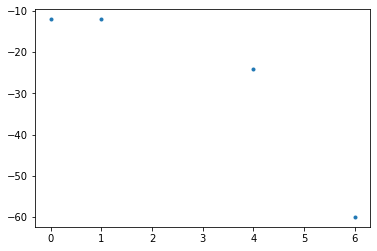

In [7]:
def interp_langrange(x_data, y_data, x):
    "A custom Lagrange interpolate function."
    "We want to interpolate over x knowning points at x_data and y_data"

    # The shape will be N x N x n, where N is the number of points
    # in x and y, and n is the number of points in the result.
    x = np.asarray(x)
    x = x.reshape(1, 1, -1)
    

    # Make grid. Have one "throw away" dimension to make [N,N,1] shaped arrays
    # uses meshgrid which return coordinate matrices from coordinate vectors, in this case x_data, x_data
    # meaning a matrix with coordinates from x_data and it returns for vectors x1, x2,…, ‘xn’ 
    # with lengths Ni=len(xi) , return (N1, N2, N3,...Nn) shaped arrays if indexing=’ij’
    
    x_n, x_i, _ = np.meshgrid(x_data, x_data, np.array([1]))
    #print('x_n=',x_n)
    #print('x_i=',x_i)

    # Using a mask here avoids numpy warnings and makes the product easy
    # where np.eye create an identity matrix
    # np.ma.array create a matrix with masked values, in this case the diagonal
    
    x_n = np.ma.array(x_n, mask=np.eye(x_data.shape[0]))
    x_i = np.ma.array(x_i, mask=np.eye(x_data.shape[0]))

    #print('x_n=',x_n)
    #print('x_i=',x_i)

    # the reason why we mask the diagonal, it is because in the polynomials the product goes
    # over all posible values except "i" (see equation 7.24 book)
    V = (x - x_n) / (x_i - x_n)
    #here is the product is along the "2nd" axis or column axis
    v = np.prod(V, axis=1).data  # Convert back to non-masked arrays

    return y_data @ v


# This was added to test interp_langrange
x_d2 = np.array([0, 1, 4, 6])
y_d2 = np.array([-12, -12, -24, -60])

interp_langrange(x_d2, y_d2, [0.5, 4])  # should be -10.125 and -60

plt.plot(x_d2,y_d2,'.')

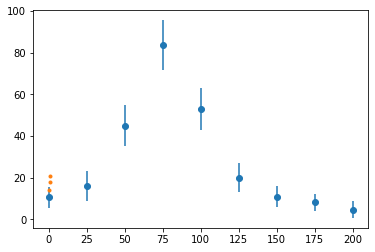

In [8]:
fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, e_data, fmt="o")
ax.plot(x, interp_langrange(x_data, y_data, x), ".")
plt.show()

Of course, you shouldn't be writing your own algorithms for something that is generally useful - it's included in SciPy. Let's see what that would have looked like instead:

In [9]:
from scipy import interpolate

In [10]:
p = interpolate.lagrange(x_data, y_data)  # Makes a callable object "p"

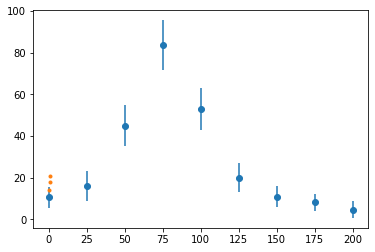

In [11]:
fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, e_data, fmt="o")
ax.plot(x, p(x), ".")
plt.show()

## Cubic splines

This is a visually appealing method for interpolation. It makes small cubic polynomial fits, with the further requirement that they smoothly connect to the next segment (thus looks better than the similar integration tool we saw earlier). Cubic splines are the most common. In this case the function is represented by a cubic polynomial within each interval and has continuous first and second derivatives at the "knots".

In [12]:
spline = interpolate.CubicSpline(x_data, y_data)
print(spline([0,2,30]))

[10.6        10.49852908 19.45682462]


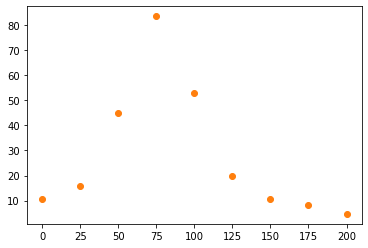

In [13]:
fig, ax = plt.subplots()
ax.plot(x, spline(x))
ax.plot(x_data, y_data, "o")
plt.show()

## Curve fitting

We'll start with using the scipy optimize package. We'll look at how to do this ourselves with a simple function later.

Basically what we want now is to use non-linear least squares to fit a function, f, to provided data

In [14]:
from scipy.optimize import curve_fit

Our fit function is a theoretical model: a Breit-Wigner resonance:

$$
f(E) =
\frac{f_r}{\left(E-E_r\right)^2 + \Gamma^2/4}
$$

In [15]:
def f(E, f_r, E_r, Γ):
    return f_r / ((E - E_r) ** 2 + Γ ** 2 / 4)

Now, we look up the definition of curve_fit (using shift-tab, `curve_fit?`, or `help(curve_fit)`), and then feed it the parameters it wants:

In [16]:
#here P0 is an initial guess for the three parameter function
#sigma determines the uncertainty in ydata.
#if absolute_sigma True, sigma is used in an absolute sense and the estimated parameter covariance 
# pcov reflects these absolute values
popt, pcov = curve_fit(
    f, x_data, y_data, p0=[1.0, 1.0, 1.0], sigma=e_data, absolute_sigma=True
)

A useful information here is that we get the covariance matrix between x_data and y_data. The covariance matrix  of two random variable $x,y$ is given by
$$
Cov(x,y) = \frac{1}{n-1} \sum_{i=1}^n (x_i - \overline{x})(y_i - \overline{y})
$$

It returns two objects; the array of fit value, and a covariance matrix.

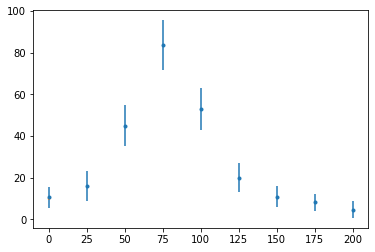

In [17]:
fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, e_data, fmt=".")
ax.plot(x, f(x, *popt))
plt.show()

## Advanced usage: The Uncertainties package

The uncertainty packages that handles calculations with numbers with uncertainties. It can also yield the derivatives of any expression. It deals with what we call error propagation.

In [18]:
from uncertainties import correlated_values, unumpy, ufloat

In [19]:
u = ufloat(1, 0.1)
print(u)

1.00+/-0.10


Let's use that correlation matrix that `curve_fit` returned in the previous section! If you have the uncertainties package, you can make uncertain values - even ones related through an covariance matrix.

In [20]:
copt = correlated_values(popt, pcov)

Now, since we can compute the value + uncertainty for a calculation, including the correct relationship between variables, we can compute the function again, and plot a shaded uncertainty band.

In [21]:
def plot_with_unc(x, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    y_nv = unumpy.nominal_values(y)
    y_sd = unumpy.std_devs(y)

    (line,) = ax.plot(x, y_nv)
    ax.fill_between(x, y_nv - y_sd, y_nv + y_sd, color=line.get_color(), alpha=0.2)

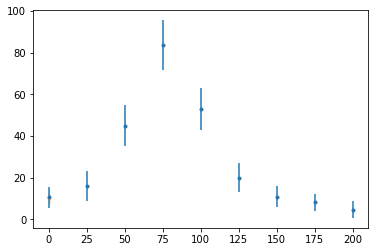

In [22]:
fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, e_data, fmt=".")
plot_with_unc(x, f(x, *copt), ax=ax)
plt.show()

## Linear least squares

Let's do a least squares fit ourselves. As long as we have a linear dependence *on the parameters*, we can solve this with linear algebra. This is nicely describe in section 7.7 in our book.

We can set the problem as follows: given a set of points ($x_i, y_i \pm \sigma_i)$, with $i=1,\cdots,N$ we need to find how well these data points are defined with a given function $g(x,{a_m})$. Of course, we do not know the parameters ${a_m}$ in advance and we need to optimize them as well.

Therefore the idea here is minimize the function
$$
\chi^2 = \sum_{i=1}^N \left( \frac{y_i - g(x_i,{a_m})}{\sigma_i} \right)^2
$$
Now the problem reduces to find the best parameters ${a_m}$ which provide the smaller value for $\chi^2$. This is just basically a minimization procedure.

In the case of the linear least squares, we want to fint a line, which means that we need to optimize over two parameters. 

Some data:

In [23]:
t = np.linspace(1, 2)
x = np.array([1.0, 1.1, 1.24, 1.35, 1.451, 1.5, 1.92])
y = np.array([0.52, 0.8, 0.7, 1.8, 2.9, 2.9, 3.6])
sig = np.array([0.1, 0.1, 0.2, 0.3, 0.2, 0.1, 0.1])

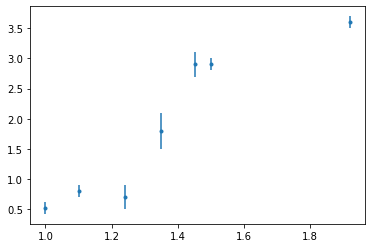

In [24]:
fig, ax = plt.subplots()
ax.errorbar(x, y, sig, fmt=".")
plt.show()

## Manual least squares fitting:

The process can be generalized to any function, as for example we could consider the fitting function:

$$
g(x_i) = a_0 x_i^2 + a_1 x_i + a_2
\tag{1}
$$

If you compute the minimum of $\chi^2$, you get:

$$
\sum _i
\frac{g(x_i)}{\sigma_i^2}
\frac{\partial g ( x_i)}{\partial a_m}
=
\sum _i
\frac{y_i}{\sigma_i^2}
\frac{\partial g ( x_i)}{\partial a_m}
\tag{2}
$$


in case you do not know
$$
\chi^2 = \sum_i \left[ \frac{y(x_i) - f(x_,a_j)}{\sigma^2}\right]
$$

We can rewrite this as a matrix expression, expanding (2) in terms of (1):

$$
A x = b
\tag{3}
$$

$$
A = \left[
\begin{matrix}
 \sum_i \frac{x_i^4}{\sigma_i^2} & \sum_i \frac{x_i^3}{\sigma_i^2} & \sum_i \frac{x_i^2}{\sigma_i^2} \\
 \sum_i \frac{x_i^3}{\sigma_i^2} & \sum_i \frac{x_i^2}{\sigma_i^2} & \sum_i \frac{x_i^1}{\sigma_i^2} \\
 \sum_i \frac{x_i^2}{\sigma_i^2} & \sum_i \frac{x_i  }{\sigma_i^2} & \sum_i \frac{1    }{\sigma_i^2} \\
\end{matrix}
\right]
\tag{3.1}
$$

$$
b = \left[
\begin{matrix}
 \sum_i \frac{y_i x_i^2}{\sigma_i^2} \\
 \sum_i \frac{y_i x_i  }{\sigma_i^2} \\
 \sum_i \frac{y_i      }{\sigma_i^2} \\
\end{matrix}
\right]
\tag{3.2}
$$

$$
x = \left[
\begin{matrix}
 a_2 \\
 a_1 \\
 a_0 \\
\end{matrix}
\right]
\tag{3.3}
$$

In [25]:
sig2 = sig ** 2
ss = np.array(
    [
        np.sum(x ** 4 / sig2),
        np.sum(x ** 3 / sig2),
        np.sum(x ** 2 / sig2),
        np.sum(x / sig2),
        np.sum(1 / sig2),
    ]
)
A = np.stack([ss[:3], ss[1:4], ss[2:]])

b = np.array([np.sum(x ** 2 * y / sig2), np.sum(x * y / sig2), np.sum(y / sig2)])
print(b)

[2344.4035725 1420.0975     892.       ]


We could have been much more clever. Looking at the above expression for M, we could instead have created the powers, then raise to a matrix of powers!

In [26]:
power = sum(np.mgrid[2:-1:-1, 2:-1:-1])
print(power)
Ap = np.sum(x[:, None, None] ** power / sig[:, None, None] ** 2, axis=0)
assert np.all(A == Ap)

[[4 3 2]
 [3 2 1]
 [2 1 0]]


Exercise for the reader: try the same trick on `b`.

In [27]:
xvec = np.linalg.solve(A, b)
print(xvec)

[-2.76280268 11.66987644 -8.5698482 ]


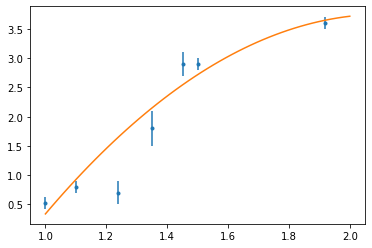

In [28]:
p = np.poly1d(xvec)
fig, ax = plt.subplots()
ax.errorbar(x, y, sig, fmt=".")
ax.plot(t, p(t))
plt.show()

#### Numpy Polyfit

I'm still not advocating that real fits be done this way. We could have just done this with the polyfit function in numpy:

In [29]:
xvec = np.polyfit(x, y, 2, w=1 / sig)
p = np.poly1d(xvec)

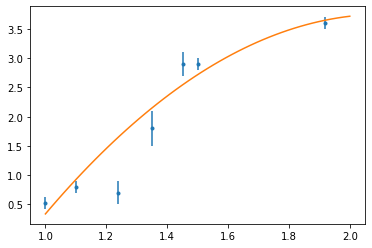

In [30]:
fig, ax = plt.subplots()
ax.errorbar(x, y, sig, fmt=".")
ax.plot(t, p(t))
plt.show()

#### Scipy curve fit

Or the more general scipy `curve_fit`:

In [31]:
def new_p(x, *values):
    return np.poly1d(values)(x)


xvec, _ = curve_fit(new_p, x, y, p0=[1, 1, 1], sigma=sig)
p = np.poly1d(xvec)

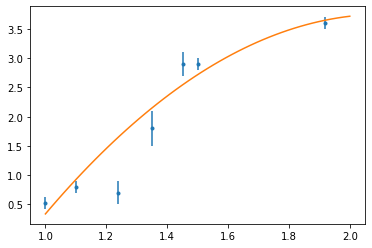

In [32]:
fig, ax = plt.subplots()
ax.errorbar(x, y, sig, fmt=".")
ax.plot(t, p(t))
plt.show()

### A 2D fit

Let's try in 2D. Try to fit the following data with a function of the form:

$$
f(x,y) =
a \sin(b x) + c \cos(d y)
$$

In [33]:
state = np.random.RandomState(42)
x, y = np.ogrid[-np.pi : np.pi : 100j, -np.pi : np.pi : 100j]
z = 1.2 * np.sin(2.3 * x) + 0.6 * np.cos(3.1 * y) + state.rand(100, 100) * 0.3

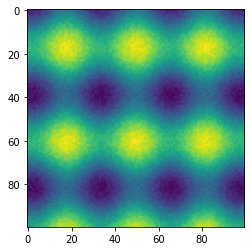

In [34]:
fig, ax = plt.subplots()
ax.imshow(z)
plt.show()

To get this into `curve_fit`, we have to jump through some hoops. We need to give x and y together (it will be used by the function exactly as we give it), and we need to return a 1D array of values to compare:

<font color="grey">

> Note: some older examples will show you a really odd syntax:
>
> ```python
> def f((x,y), a, b, c, d):
> ```
>
> This was more trouble than it was worth and was dropped in Python 3. Just unpack yourself if you want to unpack.

</font>

In [35]:
def f(xy, a, b, c, d):
    x, y = xy
    z = a * np.sin(b * x) + c * np.cos(d * y)
    return z.ravel()

We had to return a flattened array, since `curve_fit` only likes flat (1D) arrays. At this point, when computing a least squared fit, the result shape does not matter, so it's okay to do. (The fact we had to build it into our fitting function is really irritating, though). We'll need to do the same thing with `z`, as well, since it's going to be compared with the return value:

> Note: `flatten()`, `ravel()`, and `reshape(-1)` all do basically the same thing, but `flatten` always makes a copy, so `ravel` is usually better.

We'll need to broadcast our 100x1 and 1x100 arrays to 100x100 so we can flatten them:

In [36]:
xfull, yfull = np.broadcast_arrays(x, y)

In [37]:
popt, pcov = curve_fit(f, [xfull.ravel(), yfull.ravel()], z.ravel(), p0=[1, 2, 0.5, 3])

Let's use the uncertainties package again, this time to provide nicer printouts of the fit values:

In [38]:
copt = correlated_values(popt, pcov)
for i in range(4):
    print("abcd"[i], "=", format(copt[i], "P"))

a = 1.2019±0.0025
b = 2.3001±0.0010
c = 0.5952±0.0023
d = 3.0497±0.0023


Just for comparison, this is what it would have looked like if we calculated that ourselves:

In [39]:
for i in range(4):
    print("abcd"[i], "=", popt[i], "±", np.sqrt(pcov[i, i]))

a = 1.201865056760183 ± 0.0024522716182812446
b = 2.3000753649141643 ± 0.0009971958252061681
c = 0.5952341679572783 ± 0.0023497127186217666
d = 3.0496873705111316 ± 0.002285908398143492


Now, the result:

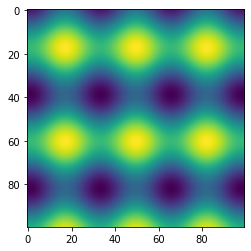

In [40]:
fig, ax = plt.subplots()
ax.imshow(f([x, y], *popt).reshape(100, 100))
plt.show()

#### Try it yourself:

* What happens if your initial guess is not as good? Why?